In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

#定义超参数
image_size = 28  # image size 28*28
num_classes = 10 # 标签的种类
num_epochs = 20  # 训练的循环周期 20
batch_size = 64  # 一个批次的大小，64张图片

(1, 28, 28)
训练集多少批： 938
训练集总共多少条： 60000
校验集多少批： 79
校验集总共多少条： 10000
测试集多少批： 79
测试集总共多少条： 10000 

The label is:  5


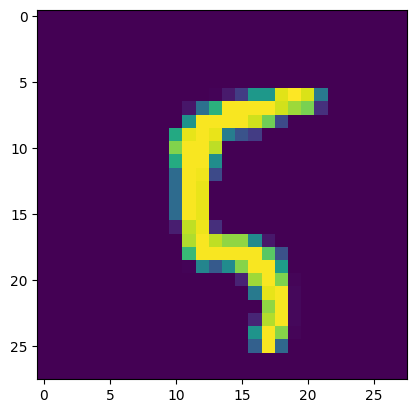

The label is:  7


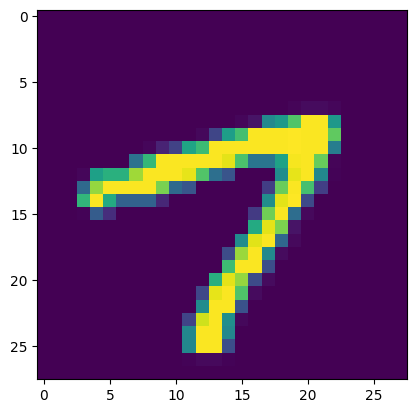

The label is:  1


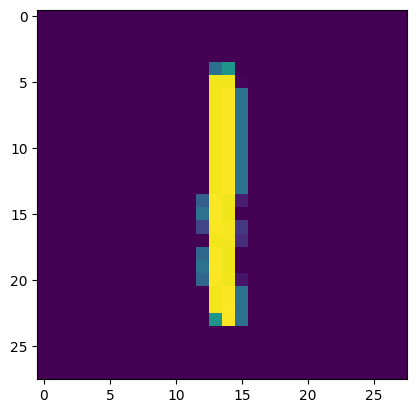

In [2]:
train_datasets = dsets.MNIST(root='./05_convolution_data', # 文件存放路径
                             train = True,  # 提取训练集
                             transform=transforms.ToTensor(), #将图像转化为Tensor
                             download = True)  # 找不到文件的时候自动下载
print(train_datasets[0][0].data.numpy().shape)

# 加载测试数据集
test_datasets = dsets.MNIST(root='./05_convolution_data', # 文件存放路径
                             train = False,  # 提取训练集
                             transform=transforms.ToTensor(),) #将图像转化为Tensor
                           
#  自动将数据切分成批，打乱顺序
train_loader = torch.utils.data.DataLoader(dataset = train_datasets,
                                           batch_size = batch_size,
                                           shuffle = True)
print('训练集多少批：', len(train_loader))
print('训练集总共多少条：', len(train_loader.dataset))

# 测试数据分为两部分，一部分校验用验证是否过拟合，一部分测试
indices = range(len(test_datasets))
indices_validate = indices[:5000]
indices_test = indices[5000:]

# 数据采样器
sampler_validate = torch.utils.data.sampler.SubsetRandomSampler(indices_validate)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 根据采样器定义加载器
validate_loader = torch.utils.data.DataLoader(dataset = test_datasets,
                                              batch_size = batch_size,
                                              shuffle = False,
                                              sampler = sampler_validate)
                                             
test_loader = torch.utils.data.DataLoader(dataset = test_datasets,
                                              batch_size = batch_size,
                                              shuffle = False,
                                              sampler = sampler_test)
print('校验集多少批：', len(validate_loader))
print('校验集总共多少条：', len(validate_loader.dataset))
print('测试集多少批：', len(test_loader))
print('测试集总共多少条：', len(test_loader.dataset), '\n')

def show_raw_img(idx):
    muteimg = train_datasets[idx][0].data.numpy()
    plt.imshow((muteimg[0,...]))   # 因为维度是1*28*28，  所以切片的第一维度索引是0， 即提取 28*28 
    print('The label is: ', train_datasets[idx][1])
    plt.show()
                                           
# 随便从数据集中读入一张图片
show_raw_img(100)
show_raw_img(101)
show_raw_img(102)

In [3]:
# 构建卷积神经网络
depth = [4, 8] # 卷积层的厚度

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()  # 调用父类构造函数

        # 卷积后图像维度不变， size + padding * 2 - kernel_size + 1 = size + 4 - 5 + 1 = size
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = 5, padding = 2) # 卷积层
        
        self.pool = nn.MaxPool2d(2, 2) #  池化层
        
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) # 第二层卷积

        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1], 512) 
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # 神经网络完成真正的前向运算，拼装各个实际的组件
        x = self.conv1(x) # 第一层卷积
        x = F.relu(x)  # (batch_size, num_filters, image_width, image_height]

        x = self.pool(x) # 第二层池化，图片变小：(batch_size, num_filters, image_width / 2, image_height / 2]

        x = self.conv2(x) #第三层卷积, (batch_size, depth[1], image_width / 2, image_height / 2]
        x = F.relu(x)  

        x = self.pool(x) #第四层池化， 图片缩小 (batch_size, depth[1], image_width / 2 / 2, image_height / 2 / 2]

        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])  # 压缩向量

        x = F.relu(self.fc1(x)) # 第五层为全连接  (batch_size, 512)

        x = F.dropout(x, training = self.training) # 默认以0.5的概率对这一层进行dropout操作，防止过拟合
        x = self.fc2(x)  # 全连接层，最终输出 （batch_size, num_classes）

        x = F.log_softmax(x, dim=1)
        return x

    def retrieve_features(self, x):
        # 返回前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)

        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)
        
# 计算分类准确度
def rightness(predictions, labels):
    # max函数返回[value, index], pred得到最大概率的索引，0表示好，1表示负面
    pred = torch.max(predictions.data, 1)[1] # max的dim=1 表示沿着第二个维度计算max，即好或坏两个分类数值， 

    rights = pred.eq(labels.data.view_as(pred)).sum()

    return rights, len(labels)

In [4]:
net = ConvNet() # 自动调用实例的init函数

criterion = nn.CrossEntropyLoss() # 定义损失函数
# 动量法每下降一步都是由前面下降方向的一个累积和（衰减系数momentum）当前点的梯度方向组合而成。
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 定义优化器, 小批量loss更新的梯度下降算法。 momentum动量法

records = [] # 记录一个epoch周期内训练集和校验集的准确率
weights = []

for epoch in range(num_epochs):
    train_rights = []
    # data维度: [64, 1, 28, 28], target维度: [64], target存储的是索引值
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # train()方法是用于在训练神经网络时启用dropout、batch normalization和其他特定于训练的操作的函数。
        net.train()
        
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad() # 清空梯度 
        loss.backward()
        optimizer.step()  # 随机梯度下降算法更新权重

        right = rightness(output, target) # 计算准确率
        train_rights.append(right)

        if batch_idx % 100 == 0:
            net.eval() # 不运行dropout，BN等训练层
            validate_rights = []

            for (data, target) in validate_loader:
                output = net(data)
                
                right = rightness(output, target)
                validate_rights.append(right)

            # 训练集准确度=train_r[0] / train_r[1]
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            # 校验集准确度=validate_r[0] / validate_r[1]
            validate_r = (sum([tup[0] for tup in validate_rights]), sum([tup[1] for tup in validate_rights]))

            # 计算一个epoch周期内的 准确率
            # 训练周期: 0 [12800 / 60000 (21%)]	, Loss: 2.259433	, 训练正确率: 14.70%	, 校验正确率: 30.50%
            print('训练周期: {} [{} / {} ({:.0f}%)]\t, Loss: {:.6f}\t, 训练正确率: {:.2f}%\t, 校验正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.data,
                100. * train_r[0] / train_r[1],
                100. * validate_r[0] / validate_r[1]
            ))

            records.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * validate_r[0] / validate_r[1]))
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(),
                           net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])

训练周期: 0 [0 / 60000 (0%)]	, Loss: 2.315790	, 训练正确率: 4.69%	, 校验正确率: 10.60%
训练周期: 0 [6400 / 60000 (11%)]	, Loss: 2.298353	, 训练正确率: 9.67%	, 校验正确率: 15.70%
训练周期: 0 [12800 / 60000 (21%)]	, Loss: 2.288557	, 训练正确率: 10.71%	, 校验正确率: 12.20%
训练周期: 0 [19200 / 60000 (32%)]	, Loss: 2.285599	, 训练正确率: 12.15%	, 校验正确率: 15.90%
训练周期: 0 [25600 / 60000 (43%)]	, Loss: 2.264396	, 训练正确率: 14.06%	, 校验正确率: 19.74%
训练周期: 0 [32000 / 60000 (53%)]	, Loss: 2.222286	, 训练正确率: 16.82%	, 校验正确率: 31.74%
训练周期: 0 [38400 / 60000 (64%)]	, Loss: 1.955185	, 训练正确率: 20.85%	, 校验正确率: 54.70%
训练周期: 0 [44800 / 60000 (75%)]	, Loss: 1.196299	, 训练正确率: 26.19%	, 校验正确率: 69.42%
训练周期: 0 [51200 / 60000 (85%)]	, Loss: 0.603490	, 训练正确率: 31.98%	, 校验正确率: 77.22%
训练周期: 0 [57600 / 60000 (96%)]	, Loss: 0.490636	, 训练正确率: 37.25%	, 校验正确率: 82.78%
训练周期: 1 [0 / 60000 (0%)]	, Loss: 0.597010	, 训练正确率: 85.94%	, 校验正确率: 83.12%
训练周期: 1 [6400 / 60000 (11%)]	, Loss: 0.474849	, 训练正确率: 84.99%	, 校验正确率: 85.60%
训练周期: 1 [12800 / 60000 (21%)]	, Loss: 0.411857	, 训练正确率: 85.14%	, 校

In [5]:
# 测试模型
net.eval() # 标志模型当前是运行阶段

vals = []
for data, target in test_loader:
    output = net(data)
    val = rightness(output, target)
    vals.append(val)

# 计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]

print(right_rate)

tensor(0.9904)


Text(0, 0.5, 'Error rate')

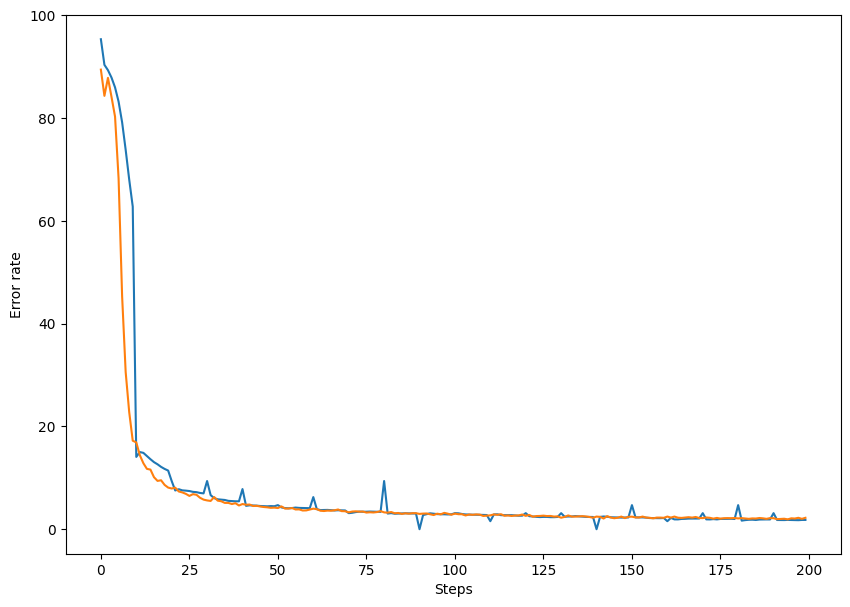

In [6]:
# 打印训练集和验证集的准确率曲线
plt.figure(figsize=(10,7))
plt.plot(records)
plt.xlabel('Steps')
plt.ylabel('Error rate')

[[ 0.16809677  0.8594434   1.193084    1.0463107   0.41809252]
 [ 0.6681018   0.9161511   1.5077071   1.1592566   0.40917867]
 [ 0.20447469  0.7651228   0.80970025  0.75439876  0.52573645]
 [-0.16529416  0.23808357  0.19181551  0.12340894  0.37940785]
 [-0.24815728 -0.09628722  0.00387959 -0.26190776 -0.02841681]]
[[-0.16440038 -0.05013942  0.0010121  -0.10903659 -0.0677866 ]
 [-0.1650332  -0.09048735 -0.16365725  0.07621773 -0.18497734]
 [ 0.18095219 -0.15606482 -0.13532506  0.168038    0.03843005]
 [-0.01703372 -0.08128748  0.01110259 -0.13561295 -0.05228492]
 [ 0.2062719  -0.08401816 -0.12975165 -0.1647717   0.19223247]]
[[-0.01714187  0.07787132 -0.18271545  0.00673107 -0.00890174]
 [-0.11394283 -0.11889275 -0.1725898   0.01784638  0.17853136]
 [-0.00355146  0.08917782  0.1331392  -0.07073693 -0.0992017 ]
 [ 0.19586772 -0.13446197  0.20143102 -0.05129642 -0.09463193]
 [ 0.13311279  0.30614042  0.21689494 -0.10053618  0.10994144]]
[[-0.08084018 -0.16844864 -0.08445574 -0.11873686 -0

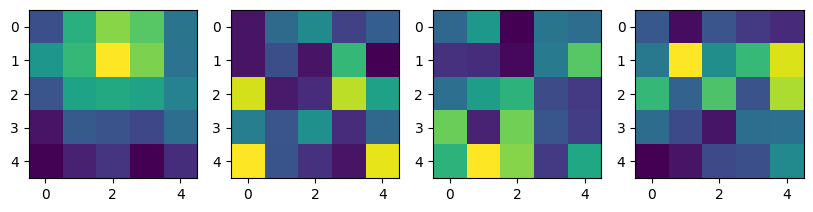

In [7]:
# 打印第一层卷积核及其图像表示
plt.figure(figsize=(10, 7))

# 4个输出通道
for i in range(4):
    plt.subplot(1, 4, i + 1)
    print(net.conv1.weight.data.numpy()[i, 0, ...])
    plt.imshow(net.conv1.weight.data.numpy()[i, 0, ...])

[[ 0.16902457  0.3348734   0.20936663 -0.36478928 -0.39088365]
 [ 0.21945113  0.4103191   0.49319056  0.35546267  0.18594399]
 [-0.34196106 -0.1430569   0.23760219  0.49425265  0.4494026 ]
 [-0.22012514 -0.31587425 -0.19627567 -0.31793526 -0.20830795]
 [ 0.05336441 -0.16432495 -0.23422475 -0.24470693 -0.09065367]]
[[-0.01447627  0.05637297 -0.09797258 -0.01593472  0.09120692]
 [ 0.09083627 -0.06386148  0.06590507  0.0206155   0.07346232]
 [-0.06055421 -0.0939038  -0.09709841  0.03750478  0.06448004]
 [ 0.06185918 -0.03775289  0.05186988  0.07618348 -0.06769989]
 [ 0.09521338 -0.07399314 -0.0851925  -0.0615922  -0.05085598]]
[[ 0.11251153 -0.03577892  0.02776065  0.09314316  0.09738165]
 [-0.04386356 -0.10082432 -0.10747671  0.07036395  0.00233032]
 [-0.06861018 -0.04138104 -0.10208802 -0.03705045 -0.01714237]
 [ 0.11607582 -0.01272327  0.0893907  -0.044132    0.08186365]
 [ 0.00362616 -0.05755926  0.04909351  0.08245184 -0.04436436]]
[[-0.09383426 -0.08272968 -0.07108856  0.01209626 -0

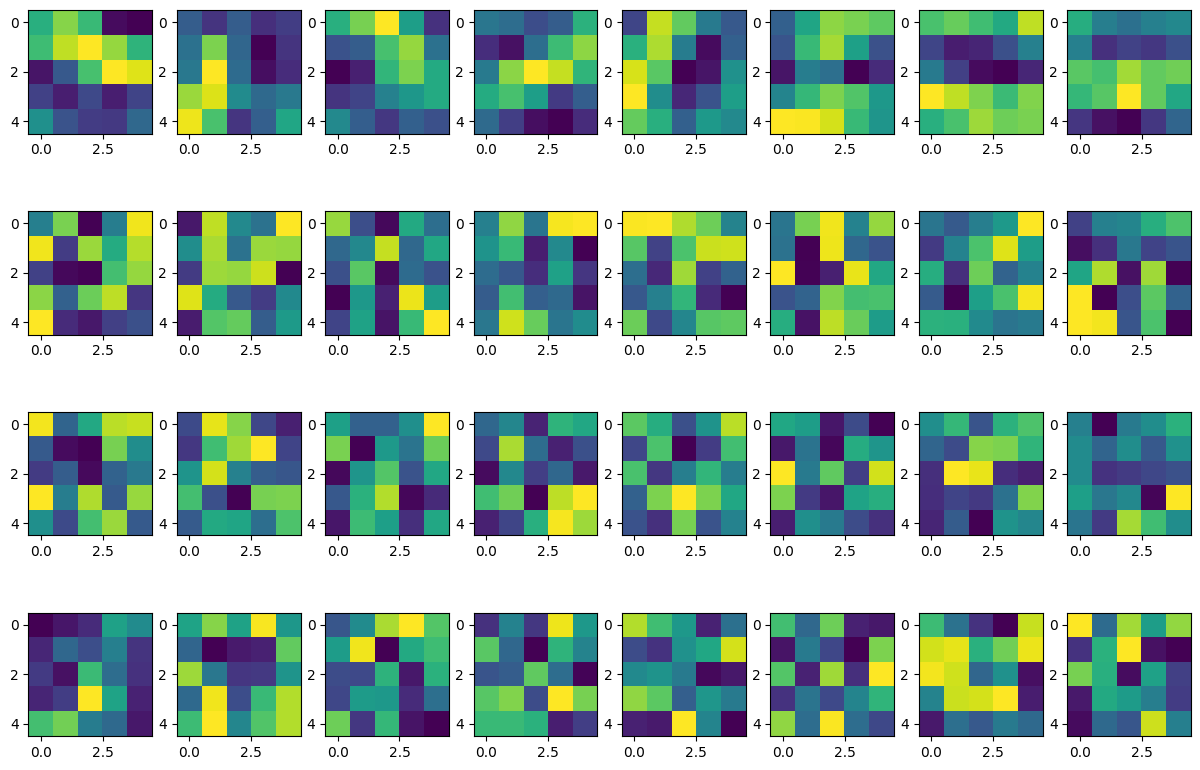

In [8]:
# 打印第二层卷积核及其图像表示
plt.figure(figsize=(15, 10))

# 4个输入通道，8个输出通道
for i in range(4):
    print(net.conv2.weight.data.numpy()[0, i, ...])  # 仅打印对应第一个输出通道的第一个卷积核， 卷积核的权重对应了4个输入通道
    for j in range(8):
        # 注意： 每一列对应了一个卷积核，一共有8个卷积核
        plt.subplot(4, 8, i * 8 + j + 1)
        plt.imshow(net.conv2.weight.data.numpy()[j, i, ...])

torch.Size([1, 8, 14, 14])


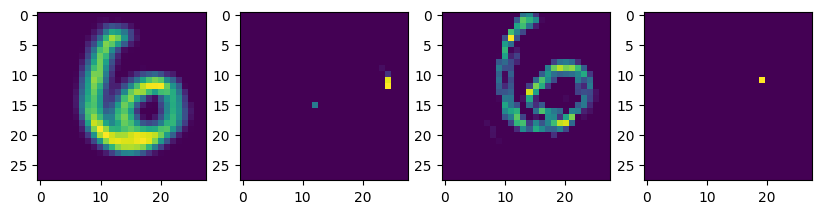

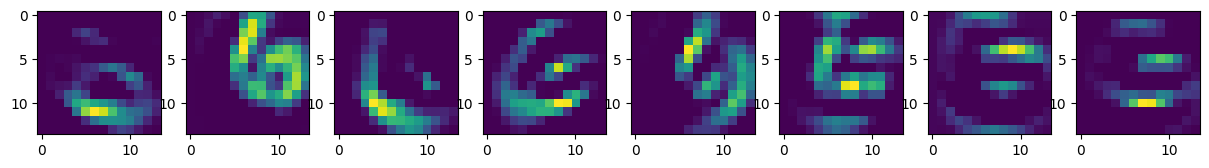

In [9]:
# 仅仅观察卷积核或其图像很难观察到什么，需要结合输入与卷积核 生成特征图
idx = 100
input_x = test_datasets[idx][0].unsqueeze(0) # unsquezze(0)：表示在第0维增加一个维度，最终变成[1, 1, 28, 28], 

feature_maps = net.retrieve_features(input_x) # 打印两个卷积层的输出
print(feature_maps[1].shape)

# 第一层卷积的特征图 (out_channels = 4)
out_channels = 4
plt.figure(figsize=(10, 7))
for i in range(out_channels):
    plt.subplot(1, out_channels, i + 1)
    plt.imshow(feature_maps[0][0, i, ...].data.numpy())

# 第二层卷积的特征图（out_channels = 8）
out_channels = 8
plt.figure(figsize=(15, 10))
for i in range(out_channels):
    plt.subplot(1, out_channels, i + 1)
    plt.imshow(feature_maps[1][0, i, ...].data.numpy())

Original Image:


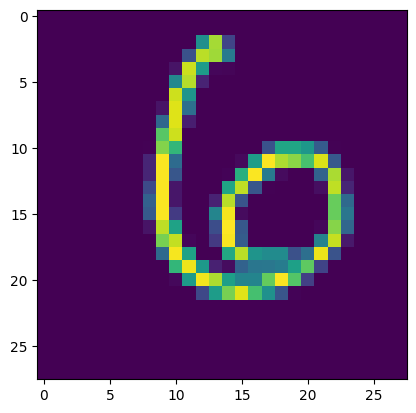

Shift to left Image:


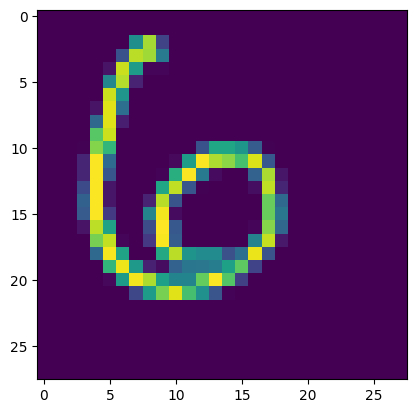

In [10]:
# 卷积神经网络的健壮性实验
# 随机挑选一张图片，平移w个单位，考察分类结果是否有变化

idx = 100
a = test_datasets[idx][0][0]  # shape: [28, 28]

b = torch.zeros(a.size())
w = 5  # 平移多少位

# 对于b中任意像素i,j，等于a中的i, j+w的位置。相当于向左平移·
for i in range(a.size()[0]):
    for j in range(a.size()[1] - w):
        b[i, j] = a[i, j + w]

print('Original Image:')
plt.figure()
plt.imshow(a.numpy())
plt.show()

print('Shift to left Image:')
plt.figure()
plt.imshow(b.numpy())


result:  tensor([5])


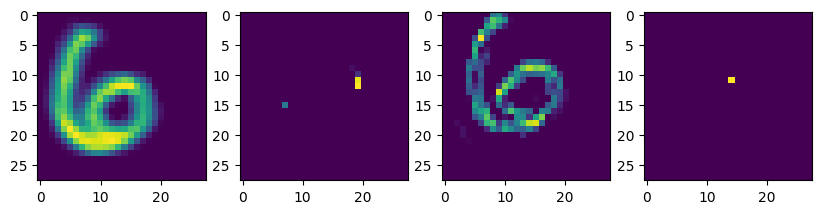

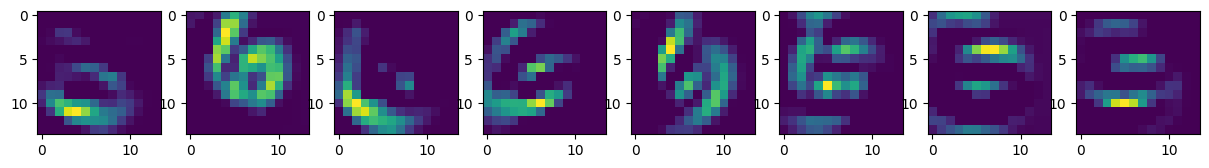

In [11]:
prediction = net(b.unsqueeze(0).unsqueeze(0))

pred = torch.max(prediction.data, 1)[1]
print('result: ', pred)  # 打印预测结果， 结果表明平移并不影响预测结果，证明池化操作进行了更大尺寸的特征提取，体现了健壮性

# 打印两层卷积层的特征图, 可以看到特征图也平移了
feature_maps = net.retrieve_features(b.unsqueeze(0).unsqueeze(0))
# 第一层卷积的特征图 (out_channels = 4)
out_channels = 4
plt.figure(figsize=(10, 7))
for i in range(out_channels):
    plt.subplot(1, out_channels, i + 1)
    plt.imshow(feature_maps[0][0, i, ...].data.numpy())

# 第二层卷积的特征图（out_channels = 8）
out_channels = 8
plt.figure(figsize=(15, 10))
for i in range(out_channels):
    plt.subplot(1, out_channels, i + 1)
    plt.imshow(feature_maps[1][0, i, ...].data.numpy())

In [13]:
# 保存训练好的模型
torch.save(net, '05_convolution_data/minst_conv_checkpoint')